In [23]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Is it possible to evaluate students' knowledge based on their exam scores and study habits?

## Introduction with the preliminary exploratory data analysis

Understanding the factors that influence student performance is critical for effective teaching and learning in the field of education. In order to group students into study knowledge levels, our study will examine student performance data and develop a predictive model. This analysis will help teachers better tailor their curriculum to suit the requirements of their students. 

We are using [User Knowledge](https://archive.ics.uci.edu/dataset/257/user+knowledge+modeling) data taken from the UC Irvine database. It is measuring students' knowledge of Electrical DC Machines. Our research question is as follows : Is it possible to predict students' knowledge based on their exam scores and study time?


In [24]:
url <- "https://raw.githubusercontent.com/naomi-ng/DSCI100-project/main/user_experience.csv"
user_experience_data <- read_csv(url, col_names = c("study_time_goal", "repetition_goal", "study_related", 
                                                   "exam_performance_related", "exam_performance_goal", "knowledge"), 
                                skip = 1)
                                 
tidy_ux_data <- user_experience_data |>
    select(-X7, -X8, -X9) |>
    mutate(knowledge = as_factor(knowledge)) |>
    mutate(study_time_goal = study_time_goal * 10) |>
    mutate(repetition_goal = repetition_goal * 10) |>
    mutate(study_related = study_related * 10) |>
    mutate(exam_performance_related = exam_performance_related * 10) |>
    mutate(exam_performance_goal = exam_performance_goal * 10) 
    
                                 
tidy_ux_data                  

Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): knowledge, X9
dbl (5): study_time_goal, repetition_goal, study_related, exam_performance_r...
lgl (2): X7, X8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0,0.00,0.0,0.0,0.0,very_low
0.8,0.80,1.0,2.4,9.0,High
0.6,0.60,0.5,2.5,3.3,Low
1.0,1.00,1.5,6.5,3.0,Middle
0.8,0.80,0.8,9.8,2.4,Low
0.9,1.50,4.0,1.0,6.6,Middle
1.0,1.00,4.3,2.9,5.6,Middle
1.5,0.20,3.4,4.0,0.1,very_low
2.0,1.40,3.5,7.2,2.5,Low


Predictor variables are as follows
- STG (study time for goal object materials)
- SCG (The degree of repetition number of user for goal object materials)
- STR (The degree of study time of user related objects with goal object)
- LPR (The exam performance of user related objects with goal object)
- PEG (exam performance of user for goal objects)

The dataset consists of 403 instances, and the knowledge levels are categorized into 4 levels which are as follows (Very low, low, middle, and high). For our data analysis, we will be using STG and PEG as the predictor variables, as they directly correlate to goal object materials. 


In [17]:
num_obs <- tidy_ux_data |>
    group_by(knowledge) |>
    summarize(counts = n())
num_obs

predictor_means <- tidy_ux_data |>
    summarize(across(study_time_goal:exam_performance_goal, mean))
predictor_means



knowledge,counts
<fct>,<int>
very_low,24
High,63
Low,83
Middle,88


study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.711473,3.556744,4.680039,4.327132,4.585388


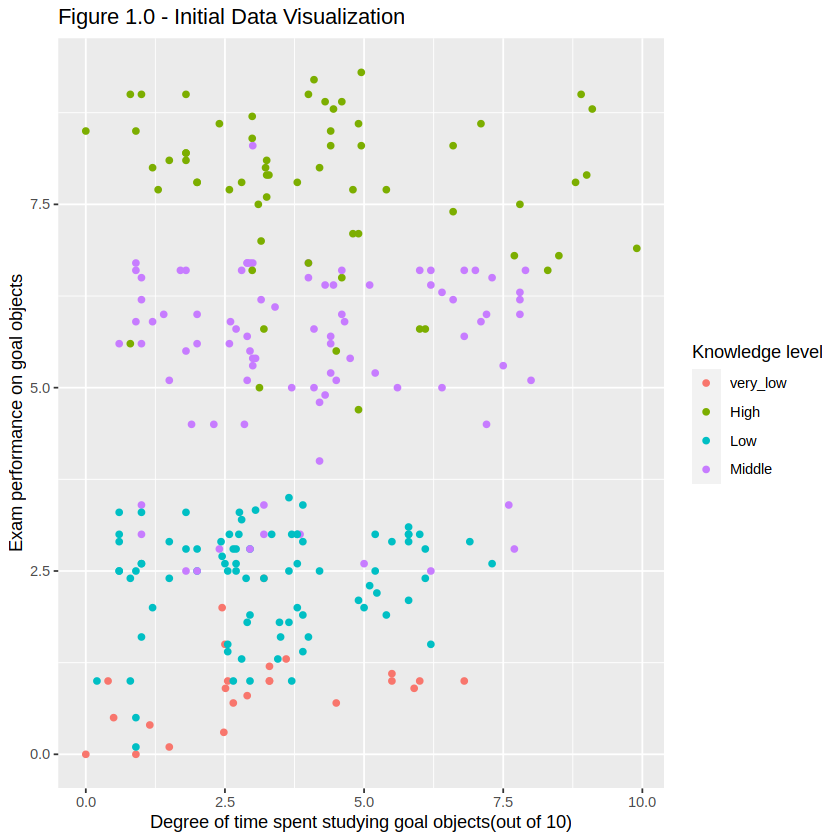

In [50]:
ux_plot <- ggplot(tidy_ux_data, aes(x = study_time_goal, y = exam_performance_goal, color = knowledge)) +
    geom_point() +
    labs(x = "Degree of time spent studying goal objects(out of 10)", 
        y = "Exam performance on goal objects", 
        color = "Knowledge level") +
    ggtitle("Figure 1.0 - Initial Data Visualization")
ux_plot

## Data Analysis

In [38]:
set.seed(3456)

ux_split <- initial_split(tidy_ux_data, prop = 0.75, strata = knowledge)
ux_train <- training(ux_split)
ux_test <- testing(ux_split)

ux_train
ux_test

study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.80,0.80,1.00,2.4,9.0,High
0.00,0.00,5.00,2.0,8.5,High
1.00,1.00,7.00,1.5,9.0,High
0.90,3.00,6.80,1.8,8.5,High
0.40,2.80,5.50,2.5,1.0,very_low
0.80,3.25,6.20,9.4,5.6,High
1.50,2.75,8.00,2.1,8.1,High
1.80,3.20,0.40,1.9,8.2,High
0.90,3.30,3.10,2.6,0.0,very_low


study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.00,1.00,1.5,6.5,3.0,Middle
0.80,0.80,0.8,9.8,2.4,Low
1.50,0.20,3.4,4.0,0.1,very_low
1.80,1.80,5.5,3.0,8.1,High
1.00,1.00,5.2,7.8,3.4,Middle
1.20,1.20,7.5,3.5,8.0,High
0.50,0.70,7.0,0.1,0.5,very_low
2.00,2.90,2.5,4.9,5.6,Middle
1.20,2.80,2.0,7.8,2.0,Low


In [39]:
train_counts <- ux_train |>
    group_by(knowledge) |>
    summarize(n = n()) 

test_counts <- ux_test |>
    group_by(knowledge) |>
    summarize(n = n())

train_counts
test_counts

## there's less very low but it makes sense as there realistically wouldn't be a very high portion of people performing poorly

knowledge,n
<fct>,<int>
very_low,17
High,45
Low,64
Middle,67


knowledge,n
<fct>,<int>
very_low,7
High,18
Low,19
Middle,21


In [40]:

ux_recipe <- recipe(knowledge ~ study_time_goal + exam_performance_goal, data = ux_train) 

ux_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

In [41]:


knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [42]:
set.seed(3456) 

ux_vfold <- vfold_cv(ux_train, v = 5, strata = knowledge)

knn_results <- workflow() |>
    add_recipe(ux_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = ux_vfold, grid = 10) |>
    collect_metrics() 

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.7416493,5,0.035271216,Preprocessor1_Model1
2,roc_auc,hand_till,0.8616771,5,0.022886516,Preprocessor1_Model1
3,accuracy,multiclass,0.7823978,5,0.009936770,Preprocessor1_Model2
3,roc_auc,hand_till,0.8795398,5,0.011026286,Preprocessor1_Model2
4,accuracy,multiclass,0.7875260,5,0.014925440,Preprocessor1_Model3
4,roc_auc,hand_till,0.8968152,5,0.014780957,Preprocessor1_Model3
6,accuracy,multiclass,0.8031878,5,0.009697058,Preprocessor1_Model4
6,roc_auc,hand_till,0.9119518,5,0.010953770,Preprocessor1_Model4
8,accuracy,multiclass,0.7818434,5,0.022326456,Preprocessor1_Model5


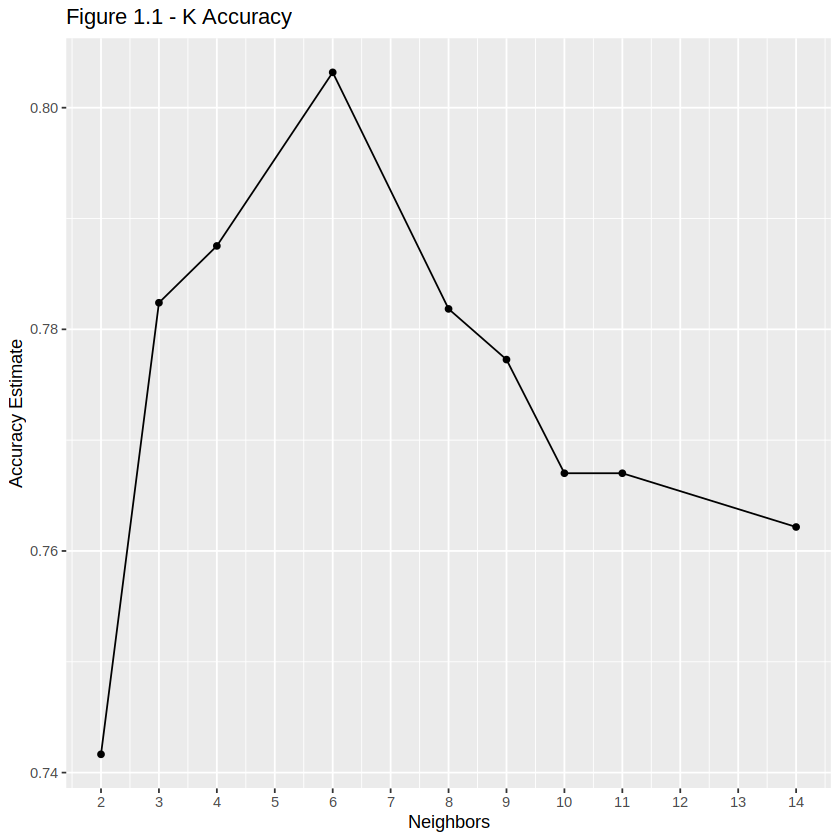

In [53]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") 

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +
    ggtitle("Figure 1.1 - K Accuracy")

accuracy_versus_k

Choose k = 6

In [44]:
ux_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("classification") 

ux_fit <- workflow() |>
    add_recipe(ux_recipe) |>
    add_model(ux_spec) |>
    fit(data = ux_train)

ux_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1865285
Best kernel: rectangular
Best k: 6

In [45]:


ux_predictions <- ux_fit |>
    predict(ux_test) |>
    bind_cols(ux_test)

ux_metrics <- ux_predictions |>
    metrics(truth = knowledge, estimate = .pred_class) |>
    filter(.metric == "accuracy")

ux_conf_mat <- ux_predictions |>
    conf_mat(truth = knowledge, estimate = .pred_class)

ux_predictions
ux_metrics
ux_conf_mat

.pred_class,study_time_goal,repetition_goal,study_related,exam_performance_related,exam_performance_goal,knowledge
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Low,1.00,1.00,1.5,6.5,3.0,Middle
Low,0.80,0.80,0.8,9.8,2.4,Low
Low,1.50,0.20,3.4,4.0,0.1,very_low
High,1.80,1.80,5.5,3.0,8.1,High
Low,1.00,1.00,5.2,7.8,3.4,Middle
High,1.20,1.20,7.5,3.5,8.0,High
Low,0.50,0.70,7.0,0.1,0.5,very_low
Middle,2.00,2.90,2.5,4.9,5.6,Middle
Low,1.20,2.80,2.0,7.8,2.0,Low


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7384615


          Truth
Prediction very_low High Low Middle
  very_low        0    0   0      0
  High            0   12   0      0
  Low             7    0  18      3
  Middle          0    6   1     18

74% accuracy 

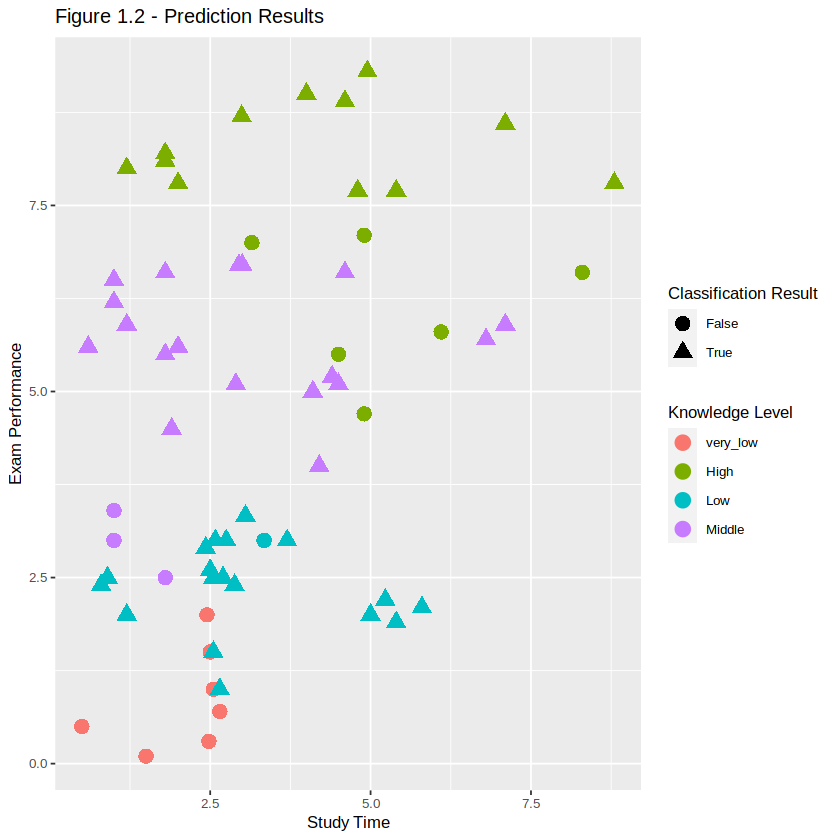

In [54]:
ux_accurate <- ux_predictions |>
    mutate(Truth = ifelse(.pred_class == knowledge, "True", "False"))

ux_plot <- ux_accurate |>
    ggplot(aes(x = study_time_goal, y = exam_performance_goal, color = knowledge, shape = Truth)) +
    geom_point(size = 4) +
    labs(x = "Study Time", y = "Exam Performance", color = "Knowledge Level", shape = "Classification Result") +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 1.2 - Prediction Results")

ux_plot

## Methods
Other variables that are related to different components of the study process and may not have as direct an impact on knowledge levels, including SCG, STR, and LPR, will be excluded. A more efficient and understandable model may result by concentrating on a smaller subset of pertinent characteristics. The dataset will be separated into training and testing sets to train and evaluate the KNN classifier.This allows us to assess the model's generalization performance to fresh data. 

Using the KNN classification algorithm, students will be classified into knowledge levels. Using the given variables (STG and PEG), the KNN model will determine the 'K' nearest neighbors in the training data for each student in the test data. A prediction will be created for each student based on the knowledge level of the majority of their closest neighbors.

We will use analyze the performance using the metrics function and calculate the accuracy, precision and recall of the classifier, to determine how well the model can accurately classify students into knowledge levels based on the given variables (STG and PEG)

## Expected Outcomes

We can find out whether exam results and actual knowledge of students are significantly correlated. Higher scores would be associated with more knowledge if there was a positive correlation; on the other hand, a negative or weak correlation might indicate that other factors are also important in determining knowledge levels. This study may also reveal how students' study practices affect their test results. It's possible that students who practice good study habits also do well on tests, which suggests that study habits have a role in learning.

## Impacts
The results of the study may have an impact on how teachers grade and assess their students. The study may support current assessment methods if it finds a significant relationship between exam results and study habits. If not, it might encourage teachers to reevaluate the significance of conventional tests and look into alternate evaluation techniques that offer a more realistic picture of students' understanding. A deeper awareness of the correlation between exam performance and study habits might be advantageous for both parents and students. Making better judgments about how to approach education, including devoting more time to productive study techniques, can result from having this knowledge.

## Further Questions
Are there specific study habits that have a stronger impact on improving exam scores and knowledge acquisition? If greater study time does not correlate with higher knowledge it could raise the question if the way the study methods affect their knowledge.

How can educators and institutions effectively teach and promote better study habits among students?: If studying a lot and doing well on exams does not correlate to ‘high knowledge’ it could raise the question if teachers need to approach their education methods in a different way.


